In [3]:
! pip install transformers datasets gradio torch scikit-learn nltk ipython-widgets

ERROR: Could not find a version that satisfies the requirement ipython-widgets (from versions: none)
ERROR: No matching distribution found for ipython-widgets


In [7]:
from datasets import load_dataset
dataset = load_dataset("aadityaubhat/GPT-wiki-intro")['train']
# extract wiki_into and generated_intro columns
dataset = dataset.map(lambda x: {'human': x['wiki_intro'], 'gpt': x['generated_intro']}, remove_columns=dataset.column_names)
# get first 1000 rows
train_ds = dataset.select(range(10000))

/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset csv (/home/alex/.cache/huggingface/datasets/aadityaubhat___csv/aadityaubhat--GPT-wiki-intro-10ad8b711a5f3880/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 1/1 [00:00<00:00, 277.00it/s]
Loading cached processed dataset at /home/alex/.cache/huggingface/datasets/aadityaubhat___csv/aadityaubhat--GPT-wiki-intro-10ad8b711a5f3880/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-cd82afa94125ed53.arrow


In [12]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

model = GPT2LMHeadModel.from_pretrained('gpt2-large').to('cuda')
tokenizer: GPT2TokenizerFast = GPT2TokenizerFast.from_pretrained('gpt2-large')

In [13]:
from tqdm import tqdm
from nltk import sent_tokenize, word_tokenize
import numpy as np
import torch
from scipy.stats import shapiro

data = []
for batch in tqdm(train_ds):
    for label in ['human', 'gpt']: 
        tokens = tokenizer(batch[label], return_tensors='pt', truncation=True).input_ids.to('cuda')
        labels = tokens.clone()
        with torch.no_grad():
            outputs = model(tokens, labels=labels)
            nll = outputs.loss
        lengths = []
        for sentence in sent_tokenize(batch[label]):
            lengths.append(len(word_tokenize(sentence)))
        data.append((nll.item(), np.mean(lengths), np.std(lengths), shapiro(lengths).pvalue if len(lengths) > 2 else 0.5, 0 if label == 'human' else 1))

 38%|███▊      | 3793/10000 [04:18<07:02, 14.69it/s]/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/scipy/stats/_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
100%|██████████| 10000/10000 [11:27<00:00, 14.55it/s]


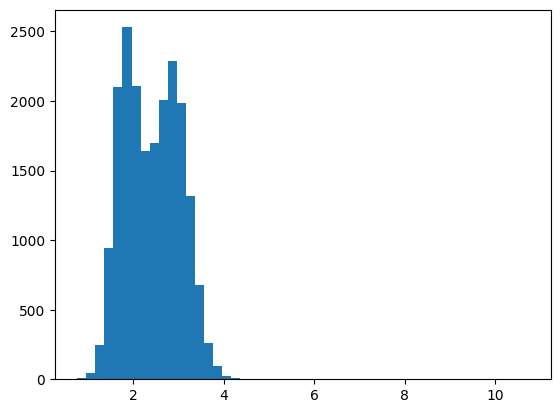

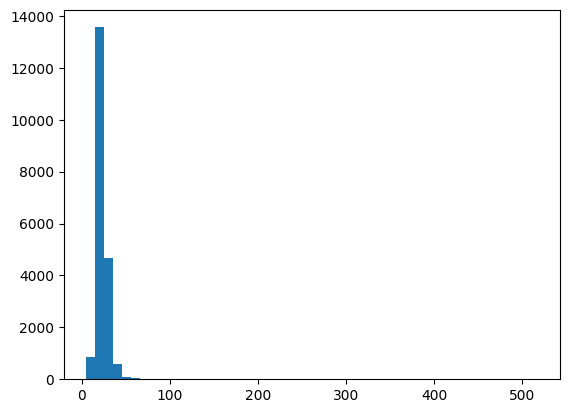

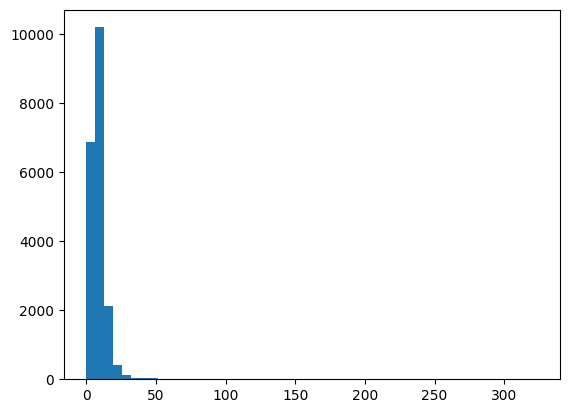

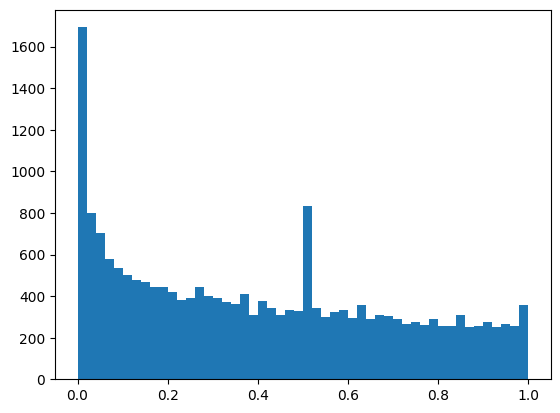

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

data = np.array(data)
# plot histograms for first 4 columns of data
import matplotlib.pyplot as plt
for i in range(4):
    plt.hist(data[:, i], bins=50)
    plt.show()

In [ ]:
# clip based on histograms
data[:, 0] = np.clip(data[:, 0], 0, 5)
data[:, 1] = np.clip(data[:, 1], 0, 100)
data[:, 2] = np.clip(data[:, 2], 0, 50)
X = data[:8000, :-1]
Y = data[:8000, -1]

X_test = data[8000:, :-1]
Y_test = data[8000:, -1]

lr_model = LogisticRegression()
lr_model.fit(X, Y)

Y_pred = lr_model.predict(X_test)
print(classification_report(Y_test, Y_pred))


In [42]:
# classify again using a simple 2 layer neural network
# Used copilot for this
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
    
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.long)

for epoch in tqdm(range(10000)):  # loop over the dataset multiple times

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(X)
    loss = criterion(outputs, Y)
    loss.backward()
    optimizer.step()

    # print statistics

print('Finished Training')

with torch.no_grad():
    outputs = net(X_test)
    _, predicted = torch.max(outputs.data, 1)
    print(classification_report(Y_test, predicted))

/tmp/ipykernel_275091/678164099.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_275091/678164099.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.long)
/tmp/ipykernel_275091/678164099.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)
/tmp/ipykernel_275091/678164099.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clo

Finished Training
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      6000
           1       0.94      0.94      0.94      6000

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000



In [15]:
import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('data.pkl', 'wb') as f:
    pickle.dump(data, f)


In [2]:
import pickle
with open('model.pkl', 'rb') as f:
    lr_model = pickle.load(f)

In [24]:
import pickle
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [30]:
print(lr_model.coef_)

[[-5.93219721 -0.12777083 -0.22496752 -0.02356617]]


In [9]:
import torch
import numpy as np
from nltk import word_tokenize, sent_tokenize
from scipy.stats import shapiro
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

model = GPT2LMHeadModel.from_pretrained('gpt2-large').to('cuda')
tokenizer: GPT2TokenizerFast = GPT2TokenizerFast.from_pretrained('gpt2-large')


In [17]:

def perplexity(text: str):
    tokens = tokenizer(text, return_tensors='pt', truncation=True, return_offsets_mapping=True)
    inputs = tokens.input_ids.to('cuda')
    targets = inputs.clone()
    with torch.no_grad():
        outputs = model(inputs, labels=targets)
        labels = targets.to(outputs.logits.device)
        # Shift so that tokens < n predict n
        shift_logits = outputs.logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        perplexities = torch.nn.functional.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1), reduce=False)
        output = []
        targets = targets.to('cpu')[0].tolist()
        # tokens = tokenizer.convert_ids_to_tokens(targets)
        offsets = tokens.offset_mapping[0].tolist()
        print(perplexities.to('cpu').tolist())
        perplexities = perplexities.to('cpu').numpy()
        perplexities = perplexities / np.max(perplexities)
        perplexities = perplexities.tolist()
        print(perplexities)
        # output.append((text[:offsets[0][1]], 0))
        # for offset, p in zip(offsets[1:], perplexities):
        #     output.append((text[offset[0]:offset[1]], p))
        #     print(type(p))
        output.append((text[:tokens.word_to_chars(0)[1]], 0))
        for word_id, p in zip(tokens.word_ids()[1:], perplexities):
            if word_id == len(output):
                span = tokens.word_to_chars(word_id)
                output.append((text[span[0]:span[1]], p))
        return output



def test_text(text):
    tokens = tokenizer(text, return_tensors='pt', truncation=True).input_ids.to('cuda')
    targets = tokens.clone()
    with torch.no_grad():
        outputs = model(tokens, labels=targets)
        nll = outputs.loss
    lengths = []
    for sentence in sent_tokenize(text):
        lengths.append(len(word_tokenize(sentence)))
    print([nll.item(), np.mean(lengths), np.std(lengths)])
    return lr_model.predict_proba([[nll.item(), np.mean(lengths), np.std(lengths), shapiro(lengths).pvalue if len(lengths) > 2 else 0.5]])[0]

In [18]:
chatgpt_sample = """
Miss Bartlett looked at Lucy with a mixture of disapproval and concern. She had hoped that this trip to Italy would broaden Lucy’s horizons and introduce her to a world beyond their sheltered English existence. But it seemed that Lucy was not quite ready to embrace the differences that came with travel."""
print(test_text(chatgpt_sample))
print(perplexity(chatgpt_sample))

[3.2869603633880615, 19.0, 5.354126134736337]
[0.98511063 0.01488937]
[9.626564025878906, 10.458065032958984, 0.9473797082901001, 7.013673305511475, 1.1930911540985107, 7.4642791748046875, 3.274026870727539, 0.812697172164917, 4.070406913757324, 0.0060477592051029205, 6.279149055480957, 0.07301952689886093, 3.441023826599121, 0.43232086300849915, 2.4097390174865723, 2.0317587852478027, 4.967353820800781, 0.9414551258087158, 3.145803213119507, 5.0301594734191895, 1.9172234535217285, 5.812107563018799, 0.37234604358673096, 7.768512725830078, 1.9835110902786255, 16.115070343017578, 10.270663261413574, 0.004315587691962719, 0.8863922357559204, 0.001679201959632337, 1.5720856189727783, 4.098275184631348, 0.09379520267248154, 0.01742401160299778, 1.9080654382705688, 2.9366698265075684, 2.703294038772583, 5.661197185516357, 7.182082653045654, 6.365976333618164, 5.099065780639648, 0.21147948503494263, 2.1655678749084473, 2.677046775817871, 2.3723464012145996, 0.7552525997161865, 1.880243778228

/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [51]:
human_sample = """
Saturn V is a retired American super heavy-lift launch vehicle developed by NASA under the Apollo program for human exploration of the Moon. 
The rocket was human-rated, with three stages, and powered with liquid fuel. It was flown from 1967 to 1973. 
It was used for nine crewed flights to the Moon, and to launch Skylab, the first American space station.
As of 2023, the Saturn V remains the only launch vehicle to carry humans beyond low Earth orbit (LEO). 
Saturn V holds records for the heaviest payload launched and largest payload capacity to low Earth orbit: 310,000 lb (140,000 kg), which included the third stage and unburned propellant needed to send the Apollo command and service module and Lunar Module to the Moon.
The largest production model of the Saturn family of rockets, the Saturn V was designed under the direction of Wernher von Braun at the Marshall Space Flight Center in Huntsville, Alabama; the lead contractors were Boeing, North American Aviation, Douglas Aircraft Company, and IBM. 
A total of 15 flight-capable vehicles were built, plus three for ground testing. 
Thirteen were launched from Kennedy Space Center with no loss of crew or payload. 
A total of 24 astronauts were launched to the Moon from Apollo 8 (December 1968) to Apollo 17 (December 1972).
"""
print(test_text(human_sample))

[2.2665181159973145, 24.7, 13.616534067081828]
[[0.6464703 0.3535297]]


In [22]:
human_sample = """
Elon Reeve Musk (born June 28, 1971) is a business magnate and investor. He is the founder, CEO and chief engineer of SpaceX; angel investor, CEO and product architect of Tesla, Inc.; owner and CEO of Twitter; founder of the Boring Company; co-founder of Neuralink and OpenAI; and president of the philanthropic Musk Foundation. With an estimated net worth of around $192 billion as of March 27, 2023, primarily from his ownership stakes in Tesla and SpaceX,[4][5] Musk is the second-wealthiest person in the world, according to both the Bloomberg Billionaires Index and Forbes's real-time billionaires list"""
print(test_text(human_sample))

[2.3605117797851562, 40.666666666666664, 16.858891488535722]
[0.96855945 0.03144055]


In [20]:
import gradio as gr

def score_text(text):
    scores = test_text(text)
    return {'Human': scores[0], 'AI': scores[1]}, perplexity(text)

sample_text = """
The Saturn V is a type of rocket that was developed by NASA in the 1960s to support the Apollo program, which aimed to land humans on the Moon. 
It remains the most powerful rocket ever built, and its five F-1 engines generated more than 7.5 million pounds of thrust at liftoff. 
The Saturn V was used for all of the Apollo missions to the Moon, as well as the launch of the Skylab space station. 
Despite its impressive capabilities, the Saturn V was only used for a brief period of time before being retired in 1973. 
Nevertheless, it remains a landmark achievement in the history of space exploration and a symbol of human ingenuity and determination."""

demo = gr.Interface(fn=score_text, inputs=[gr.Textbox(label="Text to score", lines=5, value=sample_text)], outputs=[gr.Label(), gr.HighlightedText()] )

demo.launch(debug=True)   

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


[1.6267235279083252, 25.4, 3.1368774282716245]
[3.1928133964538574, 11.090872764587402, 1.2401660680770874, 2.9397456645965576, 1.5989651679992676, 6.144593238830566, 0.05921376124024391, 0.6071777939796448, 1.2966952323913574, 1.77269446849823, 1.418119192123413, 0.8948221802711487, 1.4052410125732422, 1.362561583518982, 0.2293579876422882, 0.9151676893234253, 0.19395671784877777, 1.9493482112884521, 3.705836534500122, 0.6635450720787048, 0.9213794469833374, 0.8167247772216797, 2.1745786666870117, 1.3509793281555176, 3.217881679534912, 0.13503828644752502, 1.0101912021636963, 1.5108182430267334, 0.009972392581403255, 0.040616169571876526, 1.3157780170440674, 0.5955593585968018, 8.878231048583984, 6.160762310028076, 4.153482437133789, 5.512568473815918, 0.6207113265991211, 1.8213298320770264, 0.2258196920156479, 0.32941514253616333, 0.9138765335083008, 0.7371490597724915, 1.1995980739593506, 1.3340378999710083, 3.4415011405944824, 5.881114959716797, 6.742539882659912, 0.115135632455348

/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[3.0439934730529785, 22.6, 7.1442284397967]
[11.864895820617676, 2.0514791011810303, 9.000249862670898, 1.2321361303329468, 8.075322151184082, 3.7822072505950928, 0.8100712299346924, 4.215737342834473, 0.006572297774255276, 6.480944633483887, 0.07386036962270737, 3.5978341102600098, 0.4204569458961487, 2.3516340255737305, 1.9957952499389648, 5.545820236206055, 0.933158278465271, 3.2035279273986816, 4.9862961769104, 1.9091668128967285, 5.756060600280762, 0.3990957736968994, 7.882543563842773, 2.6852173805236816, 16.25119400024414, 10.432367324829102, 0.0038006706163287163, 1.0080170631408691, 0.001500910148024559, 1.5330770015716553, 4.130419731140137, 0.09100932627916336, 0.01775338314473629, 1.8900879621505737, 2.918238639831543, 2.757880687713623, 5.580265998840332, 7.124682903289795, 6.46763801574707, 5.205038070678711, 0.23242546617984772, 2.1020004749298096, 2.5994062423706055, 2.4229860305786133, 0.7960079908370972, 2.1522598266601562, 1.2922276258468628, 2.6557605266571045, 3.58

/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[2.4483039379119873, 19.0, 8.977095036486896]
[11.86489486694336, 2.0514755249023438, 9.000250816345215, 1.2321313619613647, 8.075323104858398, 3.7822017669677734, 0.8100698590278625, 4.215735912322998, 0.006572416052222252, 6.4809465408325195, 0.0738598182797432, 3.597837209701538, 0.4204564690589905, 2.351639747619629, 1.9957947731018066, 5.5458173751831055, 0.9331667423248291, 3.203524112701416, 4.98629093170166, 1.9091691970825195, 5.756062984466553, 0.3990977108478546, 7.882537364959717, 2.6852290630340576, 16.251188278198242, 10.432356834411621, 0.0038006706163287163, 1.0080193281173706, 0.0015010291244834661, 1.5330843925476074, 4.130419731140137, 0.09100997447967529, 0.017753617838025093, 1.8900837898254395, 2.9182400703430176, 2.7578728199005127, 5.580273628234863, 7.124689102172852, 6.467639923095703, 5.205037593841553, 0.23242877423763275, 2.102001905441284, 2.599396228790283, 2.4229817390441895, 0.7960082292556763, 2.1522603034973145, 1.2922170162200928, 2.6557509899139404,

/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


[2.536940574645996, 18.25, 5.643949562732349]
[11.864896774291992, 2.0514750480651855, 9.000249862670898, 1.232132077217102, 8.075324058532715, 3.7822036743164062, 0.8100694417953491, 4.215736389160156, 0.006572297774255276, 6.480947494506836, 0.07385948300361633, 3.5978333950042725, 0.4204567074775696, 2.351642608642578, 1.9957947731018066, 5.545816898345947, 0.9331674575805664, 3.2035255432128906, 4.986289978027344, 1.909164309501648, 5.7560601234436035, 0.39909785985946655, 7.882538318634033, 2.685230016708374, 16.251190185546875, 10.432355880737305, 0.0038006706163287163, 1.0080164670944214, 0.0015010291244834661, 1.5330841541290283, 4.130419731140137, 0.0910101905465126, 0.017753617838025093, 1.890081524848938, 2.9182398319244385, 2.757871389389038, 5.58027458190918, 7.1246843338012695, 6.4676384925842285, 5.205041885375977, 0.2324291467666626, 2.102004051208496, 2.599396228790283, 2.4229788780212402, 0.7960048913955688, 2.1522607803344727, 1.2922197580337524, 2.6557505130767822, 

/home/alex/Documents/HW4/.venv/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [2]:
from nltk import sent_tokenize
string = """Saturn V is a retired American super heavy-lift launch vehicle developed by NASA under the Apollo program for human exploration of the Moon. The rocket was human-rated, with three stages, and powered with liquid fuel. It was flown from 1967 to 1973. It was used for nine crewed flights to the Moon, and to launch Skylab, the first American space station.

As of 2023, the Saturn V remains the only launch vehicle to carry humans beyond low Earth orbit (LEO). Saturn V holds records for the heaviest payload launched and largest payload capacity to low Earth orbit: 310,000 lb (140,000 kg), which included the third stage and unburned propellant needed to send the Apollo command and service module and Lunar Module to the Moon.

The largest production model of the Saturn family of rockets, the Saturn V was designed under the direction of Wernher von Braun at the Marshall Space Flight Center in Huntsville, Alabama; the lead contractors were Boeing, North American Aviation, Douglas Aircraft Company, and IBM. A total of 15 flight-capable vehicles were built, plus three for ground testing. Thirteen were launched from Kennedy Space Center with no loss of crew or payload. A total of 24 astronauts were launched to the Moon from Apollo 8 (December 1968) to Apollo 17 (December 1972)."""

print(sent_tokenize(string))

['Saturn V is a retired American super heavy-lift launch vehicle developed by NASA under the Apollo program for human exploration of the Moon.', 'The rocket was human-rated, with three stages, and powered with liquid fuel.', 'It was flown from 1967 to 1973.', 'It was used for nine crewed flights to the Moon, and to launch Skylab, the first American space station.', 'As of 2023, the Saturn V remains the only launch vehicle to carry humans beyond low Earth orbit (LEO).', 'Saturn V holds records for the heaviest payload launched and largest payload capacity to low Earth orbit: 310,000 lb (140,000 kg), which included the third stage and unburned propellant needed to send the Apollo command and service module and Lunar Module to the Moon.', 'The largest production model of the Saturn family of rockets, the Saturn V was designed under the direction of Wernher von Braun at the Marshall Space Flight Center in Huntsville, Alabama; the lead contractors were Boeing, North American Aviation, Dougl